In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier


from preprocessing import preprocessor, numeric_features, categorical_features


In [2]:
df = pd.read_csv(r"cleaned_HealthCare_data.csv")
df.head()

,Age,Gender,Blood Type,Medical Condition,Date of Admission,Insurance Provider,Billing Amount,Admission Type,Discharge Date,Medication,Test Results,Test Results Encoded,Length of Stay
0,30,1,B-,Cancer,2024-01-31,Blue Cross,18856.281306,Urgent,2024-02-02,Paracetamol,Normal,0,2
1,62,1,A+,Obesity,2019-08-20,Medicare,33643.327287,Emergency,2019-08-26,Ibuprofen,Inconclusive,2,6
2,76,0,A-,Obesity,2022-09-22,Aetna,27955.096079,Emergency,2022-10-07,Aspirin,Normal,0,15
3,28,0,O+,Diabetes,2020-11-18,Medicare,37909.782410,Elective,2020-12-18,Ibuprofen,Abnormal,1,30
4,43,0,AB+,Cancer,2022-09-19,Aetna,14238.317814,Urgent,2022-10-09,Penicillin,Abnormal,1,20


# From Previous Milestones

In [3]:
# Create target variable (Risk)
df['Risk'] = (
    (df['Test Results'] == 'Abnormal') |
    (df['Age'] > 65) |
    (df['Medical Condition'].isin(['Diabetes', 'Hypertension', 'Asthma']))
).astype(int)

# Data Splitting

In [4]:
# Separate features and target
X = df.drop(['Test Results', 'Risk', 'Date of Admission', 'Discharge Date'], axis=1)
y = df['Risk']

In [5]:
# Check class balance
print("Class distribution:\n", y.value_counts())

Class distribution:
 Risk
1    42071
0    12895
Name: count, dtype: int64


In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

# Model Selection and Training

**1.Logistic Regression**

In [7]:
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

logreg_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Billing Amount',
                                                   'Length of Stay',
                                                   'Gender']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Blood Type',
                                                   'Medical Condition',
                                                   'Admission Type',
                                                   'Insurance Provider',
                                                   'Medication'])])),
                ('classifier', LogisticRegression())])

**2.SVM**

In [8]:
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True))
])

svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Billing Amount',
                                                   'Length of Stay',
                                                   'Gender']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Blood Type',
                                                   'Medical Condition',
                                                   'Admission Type',
                                                   'Insurance Provider',
                                                   'Medication'])])),
                ('classifier', SVC(probability=True))])

**3.Random Forest**

In [9]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Billing Amount',
                                                   'Length of Stay',
                                                   'Gender']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Blood Type',
                                                   'Medical Condition',
                                                   'Admission Type',
                                                   'Insurance Provider',
                                                   'Medication'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [10]:
# apply custom threshold for minimizing the FN
probs = rf_pipeline.predict_proba(X_test)
threshold = 0.1
test_preds_thresh = (probs[:, 1] >= threshold).astype(int)


In [11]:
# 4. Training predictions
train_probs = rf_pipeline.predict_proba(X_train)
train_preds_thresh = (train_probs[:, 1] >= threshold).astype(int)

**4. XGboost**

In [34]:
xg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

xg_pipeline.fit(X_train, y_train)

c:\Users\Lenovo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:53:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Billing Amount',
                                                   'Length of Stay',
                                                   'Gender']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Blood Type',
                                                   'Medical Condition',
                                                   'Admission Type',
                                                   'Insurance Provider',
                                                   'Medication'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

**5. MLP**

In [14]:
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42))
])

mlp_pipeline.fit(X_train, y_train)

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Billing Amount',
                                                   'Length of Stay',
                                                   'Gender']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Blood Type',
                                                   'Medical Condition',
                                                   'Admission Type',
                                                   'Insurance Provider',
                                                   'Medication'])])),
                ('classifier', MLPClassifier(max_iter=300, random_state=42))])

# Models Evaluation

**1.Logistic Regression**

In [20]:
# === Training Metrics ===
train_pred = logreg_pipeline.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)
train_precision = precision_score(y_train, train_pred, average='weighted')
train_recall = recall_score(y_train, train_pred, average='weighted')
train_f1 = f1_score(y_train, train_pred, average='weighted')

print("\nLogistic Regression - Training Metrics:")
print(f"Accuracy: {train_acc:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")


Logistic Regression - Training Metrics:
Accuracy: 0.8385
Precision: 0.8369
Recall: 0.8385
F1 Score: 0.8377


In [21]:
# === Test Metrics ===
test_pred = logreg_pipeline.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)
test_precision = precision_score(y_test, test_pred, average='weighted')
test_recall = recall_score(y_test, test_pred, average='weighted')
test_f1 = f1_score(y_test, test_pred, average='weighted')

print("\nLogistic Regression - Test Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")


Logistic Regression - Test Metrics:
Accuracy: 0.8395
Precision: 0.8383
Recall: 0.8395
F1 Score: 0.8389


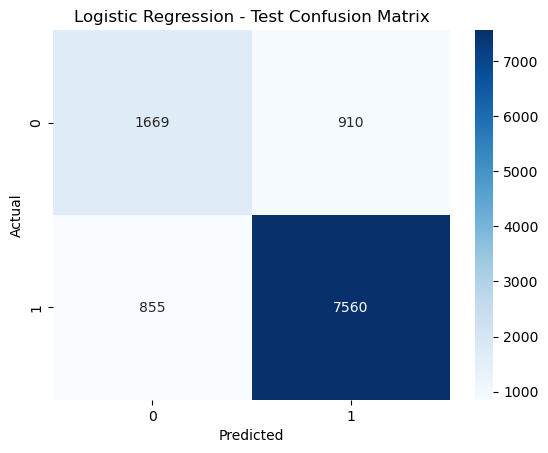

In [22]:

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, logreg_pipeline.predict(X_test), "Logistic Regression - Test Confusion Matrix")


In [26]:
joblib.dump(logreg_pipeline, "Logistic_Regression_model.pkl")
print("Model saved as Logistic_Regression_model.pkl")

Model saved as Logistic_Regression_model.pkl


**2.SVM**

In [23]:
# === Training Metrics ===
train_pred = svm_pipeline.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)
train_precision = precision_score(y_train, train_pred, average='weighted')
train_recall = recall_score(y_train, train_pred, average='weighted')
train_f1 = f1_score(y_train, train_pred, average='weighted')

print("\nSVM - Training Metrics:")
print(f"Accuracy: {train_acc:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")


SVM - Training Metrics:
Accuracy: 0.8784
Precision: 0.9071
Recall: 0.8784
F1 Score: 0.8846


In [24]:
# === Test Metrics ===
test_pred = svm_pipeline.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)
test_precision = precision_score(y_test, test_pred, average='weighted')
test_recall = recall_score(y_test, test_pred, average='weighted')
test_f1 = f1_score(y_test, test_pred, average='weighted')

print("\nSVM - Test Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")


SVM - Test Metrics:
Accuracy: 0.8693
Precision: 0.8980
Recall: 0.8693
F1 Score: 0.8758


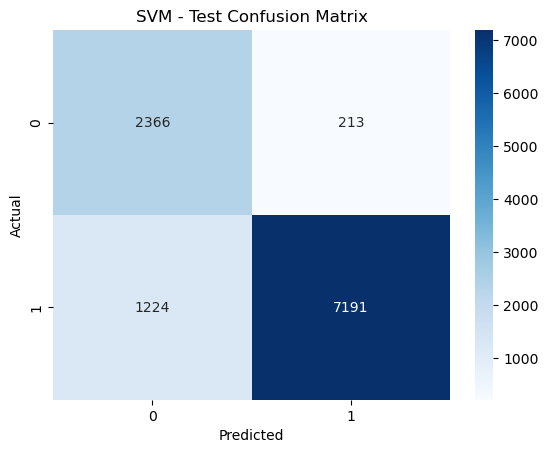

In [25]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.title(title)
    plt.show()


plot_confusion_matrix(y_test, svm_pipeline.predict(X_test), "SVM - Test Confusion Matrix")


In [27]:
joblib.dump(svm_pipeline, "SVM_model.pkl")
print("Model saved as SVM_model.pkl")

Model saved as SVM_model.pkl


**3.Random Forest**

In [28]:
# Training predictions and metrics
train_pred = rf_pipeline.predict(X_train)
train_acc = rf_pipeline.score(X_train, y_train)
train_precision = precision_score(y_train, train_pred, average='weighted')
train_recall = recall_score(y_train, train_pred, average='weighted')
train_f1 = f1_score(y_train, train_pred, average='weighted')

print("\nRandom Forest - Training Metrics:")
print(f"Accuracy: {train_acc:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")


Random Forest - Training Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [29]:
# Test predictions and metrics
test_pred = rf_pipeline.predict(X_test)
test_acc = rf_pipeline.score(X_test, y_test)
test_precision = precision_score(y_test, test_pred, average='weighted')
test_recall = recall_score(y_test, test_pred, average='weighted')
test_f1 = f1_score(y_test, test_pred, average='weighted')

print("\nRandom Forest - Test Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")


Random Forest - Test Metrics:
Accuracy: 0.8806
Precision: 0.8984
Recall: 0.8806
F1 Score: 0.8852


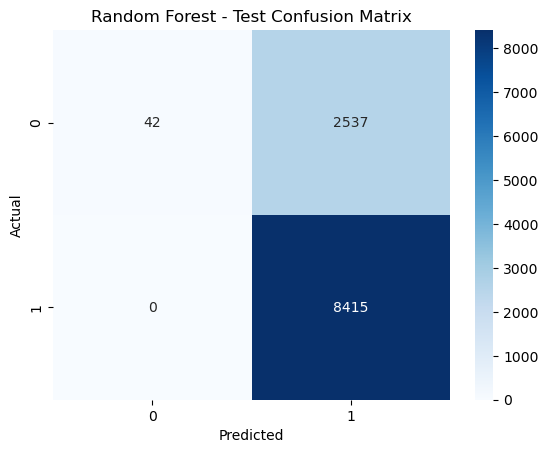

In [30]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, test_preds_thresh, "Random Forest - Test Confusion Matrix")

In [31]:
joblib.dump(rf_pipeline, "RF_model.pkl")
print("Model saved as RF_model.pkl")

Model saved as RF_model.pkl


**4. XGBoost**

In [ ]:
# Training predictions and metrics
train_pred = xg_pipeline.predict(X_train)
train_acc = xg_pipeline.score(X_train, y_train)
train_precision = precision_score(y_train, train_pred, average='weighted')
train_recall = recall_score(y_train, train_pred, average='weighted')
train_f1 = f1_score(y_train, train_pred, average='weighted')

print("XGBoost - Training Metrics:")
print(f"Accuracy: {train_acc:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")

\XGBoost - Training Metrics:
Accuracy: 0.9242
Precision: 0.9399
Recall: 0.9242
F1 Score: 0.9272


<>:8: SyntaxWarning: invalid escape sequence '\X'
<>:8: SyntaxWarning: invalid escape sequence '\X'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22172\2035097658.py:8: SyntaxWarning: invalid escape sequence '\X'
  print("\XGBoost - Training Metrics:")


In [ ]:
# Test predictions and metrics
test_pred = xg_pipeline.predict(X_test)
test_acc = xg_pipeline.score(X_test, y_test)
test_precision = precision_score(y_test, test_pred, average='weighted')
test_recall = recall_score(y_test, test_pred, average='weighted')
test_f1 = f1_score(y_test, test_pred, average='weighted')

print("XGBoost - Test Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

\XGBoost - Test Metrics:
Accuracy: 0.8703
Precision: 0.8957
Recall: 0.8703
F1 Score: 0.8764


<>:8: SyntaxWarning: invalid escape sequence '\X'
<>:8: SyntaxWarning: invalid escape sequence '\X'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22172\2924486167.py:8: SyntaxWarning: invalid escape sequence '\X'
  print("\XGBoost - Test Metrics:")


In [39]:
joblib.dump(xg_pipeline, "XG_Model.pkl")
print("Model saved as XG_model.pkl")

Model saved as XG_model.pkl


**5.mlp**

In [18]:
# Training predictions and metrics
train_pred = mlp_pipeline.predict(X_train)
train_acc = mlp_pipeline.score(X_train, y_train)
train_precision = precision_score(y_train, train_pred, average='weighted')
train_recall = recall_score(y_train, train_pred, average='weighted')
train_f1 = f1_score(y_train, train_pred, average='weighted')

print("\nMLP - Training Metrics:")
print(f"Accuracy: {train_acc:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")


MLP - Training Metrics:
Accuracy: 0.9074
Precision: 0.9146
Recall: 0.9074
F1 Score: 0.9096


In [17]:
# Test predictions and metrics
test_pred = mlp_pipeline.predict(X_test)
test_acc = mlp_pipeline.score(X_test, y_test)
test_precision = precision_score(y_test, test_pred, average='weighted')
test_recall = recall_score(y_test, test_pred, average='weighted')
test_f1 = f1_score(y_test, test_pred, average='weighted')

print("\nMLP - Test Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")


MLP - Test Metrics:
Accuracy: 0.8553
Precision: 0.8643
Recall: 0.8553
F1 Score: 0.8586


In [32]:
joblib.dump(mlp_pipeline, "MLP_model.pkl")
print("Model saved as MLP_model.pkl")

Model saved as MLP_model.pkl


# Model optimization

**Random search**

In [40]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [41]:
param_distributions = {
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__class_weight': [None, 'balanced']
}

In [42]:
random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['Age',
                                                                                'Billing '
                                                                                'Amount',
                                                                                'Length '
                                                                                'of '
                                                                                'Stay',
                                                                                'Gender']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['Blood '
                                                                                'Type',
                                                                                'Medical '
                                                                                'Condition',
                                                                                'Admission '
                                                                                'Type',
                                                                                'Insurance '
                                                                                'Provider',
                                                                                'Medication'])])),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__class_weight': [None,
                                                                     'balanced'],
                                        'classifier__max_depth': [5, 10, 15,
                                                                  None],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [50, 100,
                                                                     150,
                                                                     200]},
                   random_state=42, scoring='f1_weighted', verbose=2)

In [43]:
best_rf = random_search.best_estimator_

In [44]:
def evaluate_model(model, X, y, title=''):
    preds = model.predict(X)
    acc = accuracy_score(y, preds)
    prec = precision_score(y, preds, average='weighted')
    rec = recall_score(y, preds, average='weighted')
    f1 = f1_score(y, preds, average='weighted')
    print(f"\n{title} Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    cm = confusion_matrix(y, preds)
    ConfusionMatrixDisplay(cm).plot()


Training Metrics:
Accuracy: 0.9954
Precision: 0.9955
Recall: 0.9954
F1 Score: 0.9954


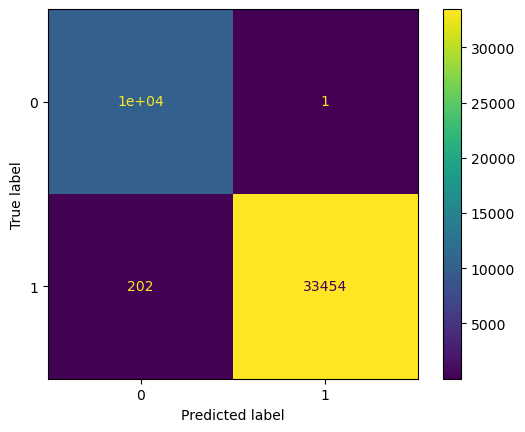

In [45]:
evaluate_model(best_rf, X_train, y_train, "Training")



Test Metrics:
Accuracy: 0.8882
Precision: 0.9134
Recall: 0.8882
F1 Score: 0.8936


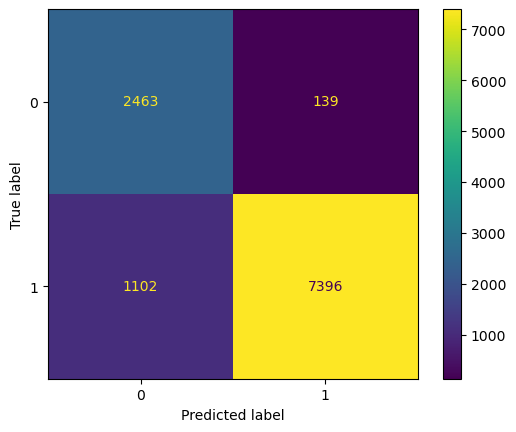

In [105]:
evaluate_model(best_rf, X_test, y_test, "Test")

In [46]:
import joblib
joblib.dump(best_rf, 'best_random_forest_pipeline.pkl')

['best_random_forest_pipeline.pkl']